Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

# Regression 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [ ] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [ ] Engineer at least two new features. (See below for explanation & ideas.)
- [ ] Fit a linear regression model with at least two features.
- [ ] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Add your own stretch goal(s) !

In [1]:
%%capture
import sys

DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',100)

# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv', parse_dates=['created'], index_col='created')
# assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

In [4]:
df = df.sort_index()
df.head(3)

,bathrooms,bedrooms,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
created,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-04-01 22:12:41,1.0,1,X-LARGE Flex 1BR Loft! ~~ PRIME Greenwich Vill...,Astor Place,40.7302,-73.9924,3195,1 Astor Place,high,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-01 22:56:00,1.0,0,"This Enormous Studio Features: Harwood Floors,...",East 54th Street,40.7576,-73.9677,2000,230 East 54th Street,medium,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-01 22:57:15,2.0,3,--- East 31st St & Lexington Avenue --- This S...,East 31st St & Lexington Avenue,40.7388,-73.9851,5850,105 Lexington Avenue,high,1,1,0,1,1,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [5]:
## First my strangest idea. Let's see if number of exclamation points in the
## listing description has any relation to price.

des_exclaims = np.array([])

for des in df['description']:
    if type(des) == str:
        count = des.count('!')
    else:
        count = 0
    des_exclaims = np.append(des_exclaims, count)
    
des_exclaims.mean()

1.9478870065755782

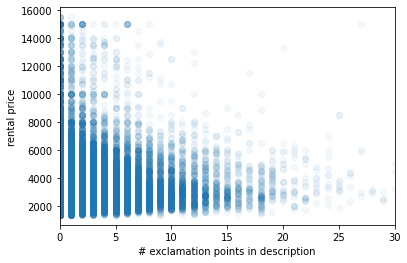

In [6]:
plt.scatter(des_exclaims, df['price'], alpha=.05)

plt.xlabel('# exclamation points in description')
plt.ylabel('rental price')

plt.xlim([0,30])
plt.show()

In [7]:
## It's not perfectly linear, but there's clearly somewhat of a
## trend. We'll add it as a feature.

df['exclamations'] = des_exclaims

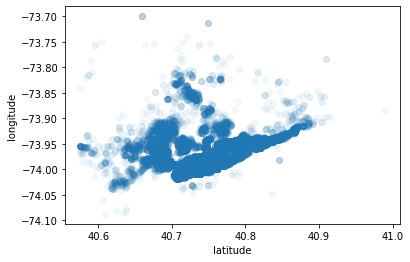

In [8]:
## Now let's look at a map and see if anything stands out.

plt.scatter(df['latitude'], df['longitude'], alpha=.05)

plt.xlabel('latitude')
plt.ylabel('longitude')

plt.show()

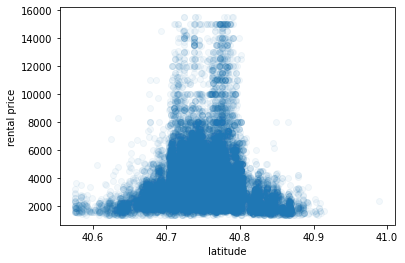

In [9]:
## Looks like there's a good bit of variance along the latitude 
## axis. Let's plot latitude vs price.

plt.scatter(df['latitude'], df['price'], alpha=.05)

plt.xlabel('latitude')
plt.ylabel('rental price')

plt.show()

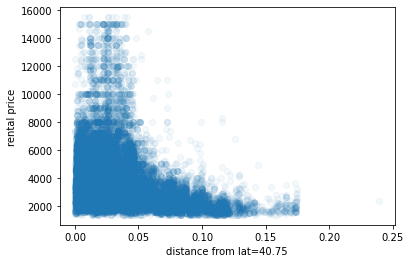

In [10]:
## Interesting. Price seems to rise as we go towards the center of
## our latitudes. I eyeballed the center as 40.75, and plotted price
## against distance from this center.

plt.scatter((abs(df['latitude']-40.75)), df['price'], alpha=.05)

plt.xlabel('distance from lat=40.75')
plt.ylabel('rental price')

plt.show()

In [11]:
## Let's add that as a feature!

df['lat_from_center'] = abs(df['latitude']-40.75)

In [12]:
## Now, the great Luxury Score... I took all the boolean features and iterated
## through them, doing mini model fittings and checking the coefficient of the
## bool feature in question (I included bedroom and bathroom to make sure the 
## model was reasonable to start with).
##
## Basically I sorted these features by their coefficient in these mini models.
## Having a high slope means that the feature adds a lot of value. I then divided
## by MAE to get my weights. I decided to use the top 7 luxuries, and a few cells
## down I combine them (with their weights) to make the lux_score column.

bool_feats = df.loc[:,'elevator':'common_outdoor_space'].columns
slopes = []
MAEs = []

for feat in bool_feats:
    y = df['price']
    X = df[[feat, 'bedrooms', 'bathrooms']]

    model = LinearRegression()
    model.fit(X=X, y=y)

    slopes.append(model.coef_[0])
    MAEs.append(mean_absolute_error(y, model.predict(X)))
    
df_bool_slopes = pd.DataFrame({'feat':bool_feats, 'slope':slopes, 'MAE':MAEs})
df_bool_slopes['ratio'] = df_bool_slopes['slope'] / df_bool_slopes['MAE']
    
seven_luxuries = df_bool_slopes.sort_values(by='ratio', ascending=False).head(7)
seven_luxuries

,feat,slope,MAE,ratio
4,doorman,747.481162,775.005821,0.964485
8,fitness_center,582.636834,796.894505,0.731134
10,laundry_in_unit,568.506670,813.477074,0.698860
0,elevator,504.508322,795.043435,0.634567
16,swimming_pool,492.195911,818.900365,0.601045
13,dining_room,410.624642,822.759792,0.499082
18,terrace,369.457265,821.254179,0.449870


In [13]:
seven_luxuries = seven_luxuries.reset_index().drop('index', axis=1)
seven_luxuries

,feat,slope,MAE,ratio
0,doorman,747.481162,775.005821,0.964485
1,fitness_center,582.636834,796.894505,0.731134
2,laundry_in_unit,568.506670,813.477074,0.698860
3,elevator,504.508322,795.043435,0.634567
4,swimming_pool,492.195911,818.900365,0.601045
5,dining_room,410.624642,822.759792,0.499082
6,terrace,369.457265,821.254179,0.449870


In [15]:
## Make lux_score column

feat = seven_luxuries['feat']
weight = seven_luxuries['ratio']

df['lux_score'] = 0

for i in range(len(feat)):
    df['lux_score'] += weight[i]*df[feat[i]]

In [16]:
## NOW -- time to split the dataframe and fit the model.

df_train = df[(df.index.month == 4) | (df.index.month == 5)]
df_test = df[df.index.month == 6]

print(df.shape)
print(df_train.shape)
print(df_test.shape)

assert df.shape[0] == df_train.shape[0] + df_test.shape[0]

(48817, 36)
(31844, 36)
(16973, 36)


In [17]:
model_features = [
                  'exclamations',
                  'lat_from_center',
                  'lux_score',
                  'bedrooms',
                  'bathrooms'
                 ]

In [18]:
y_train = df_train['price']
X_train = df_train[model_features]

y_test = df_test['price']
X_test = df_test[model_features]

In [19]:
X_train.head()

,exclamations,lat_from_center,lux_score,bedrooms,bathrooms
created,,,,,
2016-04-01 22:12:41,4.0,0.0198,1.599052,1,1.0
2016-04-01 22:56:00,3.0,0.0076,0.000000,0,1.0
2016-04-01 22:57:15,1.0,0.0112,2.330186,3,2.0
2016-04-01 23:26:07,6.0,0.0439,2.330186,1,1.0
2016-04-02 00:48:13,5.0,0.0284,1.599052,1,1.0


In [20]:
model = LinearRegression()
model.fit(y=y_train, X=X_train)

LinearRegression()

In [21]:
print('--MAE--')
print('Train:', mean_absolute_error(y_train, model.predict(X_train)))
print('Test:', mean_absolute_error(y_test, model.predict(X_test)))

--MAE--
Train: 720.5010028347202
Test: 726.0941870283768


In [22]:
print('--RMSE--')
print('Train:', mean_squared_error(y_train, model.predict(X_train), squared=False))
print('Test:', mean_squared_error(y_test, model.predict(X_test), squared=False))

--RMSE--
Train: 1123.8826468600419
Test: 1111.990495031278


In [23]:
print('--R^2--')
print('Train:', model.score(X_train, y_train))
print('Test:', model.score(X_test, y_test))

--R^2--
Train: 0.5932042753637301
Test: 0.6021510940643393


In [40]:
model.coef_

array([   -36.2257199 , -12870.3851551 ,    279.150943  ,    481.415005  ,
         1768.54025172])

In conclusion...

For each exclamation point in the description of a listing, the rental price goes down by \\$36.<br>
For each thousandth of a latitude mark away from 40.75, the price goes down by \\$12.87.<br>
For each step on the Luxury Score, price increases by \\$279.<br>
For each bedroom, \\$481.<br>
For each bathroom, \\$1768.<br>